In [23]:
import numpy as np
from dataclasses import dataclass
from numpy import float64, ndarray, dtype


def naive_power(energy: float, time: float, timebase: float = 1.) -> float:
    """energy [Wh], time [h|s], use timebase=1 if time in hours, or timebase=3600 if time in seconds"""
    return np.divide(energy, time / timebase)


def naive_energy(power: float, time: float, timebase: float = 1.) -> float:
    """power [W], time [h|s], use timebase=1 if time in hours, or timebase=3600 if time in seconds"""
    return power * (time / timebase)


@dataclass
class Panel:
    efficiency: float
    area: float
    mppt_maximum_power: float

    def run(self, irradiation: float) -> float:
        output_power = irradiation * self.area * self.efficiency
        if output_power > self.mppt_maximum_power:
            output_power = self.mppt_maximum_power
        return output_power


@dataclass
class Motor:
    maximum_power: float

    def run(self, throttle: float) -> float:
        throttle = np.clip(throttle, 0, 1)

        input_power = throttle * self.maximum_power
        if input_power > self.maximum_power:
            input_power = self.maximum_power
        return input_power


@dataclass(init=False)
class Battery:
    efficiency: float
    energy: float
    soc: float
    minimum_soc: float
    maximum_energy: float
    minimum_energy: float
    maximum_power: float

    def __init__(
        self,
        soc_0: float,
        minimum_soc: float,
        efficiency: float,
        maximum_energy: float,
        maximum_power: float,
    ):
        self.efficiency = efficiency
        self.soc = soc_0
        self.minimum_soc = minimum_soc
        self.energy = soc_0 * maximum_energy
        self.maximum_energy = maximum_energy
        self.minimum_energy = maximum_energy * minimum_soc
        self.maximum_power = maximum_power

    def _charge(self, dt: float, power: float) -> float:
        energy = naive_energy(power, dt, timebase=3600)
        self.energy += energy * self.efficiency

        if self.energy > self.maximum_energy:
            exceeded_energy = self.energy - self.maximum_energy
            self.energy -= exceeded_energy
            exceeded_power = naive_power(exceeded_energy, dt, timebase=3600)
            return power - exceeded_power

        return power

    def _discharge(self, dt: float, power: float) -> float:
        energy = naive_energy(power, dt, timebase=3600)
        self.energy -= energy * self.efficiency

        if self.energy < self.minimum_energy:
            exceeded_energy = self.minimum_energy - self.energy
            self.energy += exceeded_energy
            exceeded_power = naive_power(exceeded_energy, dt, timebase=3600)
            return power - exceeded_power

        return power

    def run(self, dt: float, target_power: float) -> float:
        power = 0.
        if target_power > 0:
            power = self._charge(dt, abs(target_power))
        else:
            power = -self._discharge(dt, abs(target_power))

        self.soc = self.energy / self.maximum_energy
        return power


@dataclass
class Other:
    power: float


@dataclass
class Boat:
    panel: Panel
    motor: Motor
    battery: Battery
    circuits: Other

    def run(self, dt: float, irradiation: float, motor_throttle: float):
        # TODO: Create exeption types and throw then in case of battery under or over voltage. This battery exception might be implemented as a BMS model, which could be disabled.
        # TODO: Create some way to programatically inject an exception, to simulate catastrophic events like crashes, which could take the boat off the race.

        # Step #1 - solve for battery:
        target_circuits_power = self.circuits.power
        target_pv_power = self.panel.run(irradiation)
        target_motor_power = self.motor.run(motor_throttle)
        target_battery_power = (
            target_pv_power - target_motor_power - target_circuits_power
        )
        actual_battery_power = self.battery.run(dt, target_battery_power)

        # Step #2 - solve for base circuits
        # if target_circuits_power > actual_battery_power:
        #     raise Exception("There is no power to keep the basic boat's circuits running!")
        actual_circuits_power = target_circuits_power

        # Step #3 - solve for pv:
        actual_pv_power = (
            actual_battery_power + target_motor_power + actual_circuits_power
        )
        if actual_pv_power > target_pv_power:
            actual_pv_power = target_pv_power

        # Step #4 - solve for motor:
        actual_motor_power = (
            actual_pv_power - actual_battery_power - actual_circuits_power
        )
        if actual_motor_power > target_motor_power:
            actual_motor_power = target_motor_power

        return (
            self.battery.soc,
            actual_pv_power,
            actual_motor_power,
            actual_battery_power,
            target_pv_power,
            target_motor_power,
            target_battery_power,
            motor_throttle,
        )


In [24]:
import pytz
from numpy.typing import NDArray  # type: ignore
from numpy import datetime64, float64, ndarray, dtype  # type: ignore
from typing import Any
import pandas as pd
from pandas import Timestamp
from datetime import datetime
from abc import ABC, abstractmethod


@dataclass
class BoatInputData:
    time: NDArray[timedelta64]  # type: ignore
    poa: NDArray[float64]


@dataclass
class BoatOutputData:
    battery_output_energy: NDArray[float64]
    pv_output_power: NDArray[float64]
    motor_output_power: NDArray[float64]
    battery_output_power: NDArray[float64]
    pv_target_power: NDArray[float64]
    motor_target_power: NDArray[float64]
    battery_target_power: NDArray[float64]
    motor_target_throttle: NDArray[float64]


class EnergyController(ABC):
    @abstractmethod
    def run(self, dt: float, input_data: BoatInputData, output_data: BoatOutputData, boat: Boat) -> float:
        ...


@dataclass
class EventResult:
    name: str
    input_data: BoatInputData
    output_data: BoatOutputData


@dataclass
class Event:
    name: str
    description: str
    # route: list[tuple[float, float]]
    start: Timestamp
    end: Timestamp

    def run(self, input_data: BoatInputData, boat: Boat, energy_controller: EnergyController) -> EventResult:
        # Transform time vector to seconds
        t = input_data.time.astype(np.int64)
        t = ((t - t[0]) * 1e-9)

        output_data = BoatOutputData(
            battery_output_energy=np.zeros(t.size, dtype=float64),
            pv_output_power=np.zeros(t.size, dtype=float64),
            motor_output_power=np.zeros(t.size, dtype=float64),
            battery_output_power=np.zeros(t.size, dtype=float64),
            pv_target_power=np.zeros(t.size, dtype=float64),
            motor_target_power=np.zeros(t.size, dtype=float64),
            battery_target_power=np.zeros(t.size, dtype=float64),
            motor_target_throttle=np.zeros(t.size, dtype=float64)
        )

        dt: np.int64 = t[1] - t[0]
        for k in range(t.size):
            if k > 0:
                dt = t[k] - t[k-1]

            control = energy_controller.run(
                dt=dt,
                input_data=BoatInputData(
                    time=input_data.time[k],
                    poa=input_data.poa[k]
                ),
                output_data=BoatOutputData(
                    battery_output_energy=output_data.battery_output_energy[k],
                    pv_output_power=output_data.pv_output_power[k],
                    motor_output_power=output_data.motor_output_power[k],
                    battery_output_power=output_data.battery_output_power[k],
                    pv_target_power=output_data.pv_target_power[k],
                    motor_target_power=output_data.motor_target_power[k],
                    battery_target_power=output_data.battery_target_power[k],
                    motor_target_throttle=output_data.motor_target_throttle[k]
                ),
                boat=boat
            )

            y = boat.run(dt, input_data.poa[k], control)

            output_data.battery_output_energy[k] = y[0]
            output_data.pv_output_power[k] = y[1]
            output_data.motor_output_power[k] = y[2]
            output_data.battery_output_power[k] = y[3]
            output_data.pv_target_power[k] = y[4]
            output_data.motor_target_power[k] = y[5]
            output_data.battery_target_power[k] = y[6]
            output_data.motor_target_throttle[k] = y[7]

        return EventResult(name=self.name, input_data=input_data, output_data=output_data)


@dataclass
class CompetitionResult:
    name: str
    results: list[EventResult]


@dataclass
class Competition:
    name: str
    events: list[Event]

    def run(self, input_data: BoatInputData, boat: Boat, energy_controller: EnergyController) -> CompetitionResult:
        competition_start: datetime64 = pd.Timestamp(
            self.events[0].start).to_datetime64()
        competition_end: datetime64 = pd.Timestamp(
            self.events[-1].end).to_datetime64()

        if input_data.time.size != input_data.poa.size:
            raise ValueError(
                "All data must have the same length as the given time array.")
        if input_data.time[0] > competition_start:
            raise ValueError(
                "Given data can't start after the first event's start.")
        if input_data.time[-1] < competition_end:
            raise ValueError(
                "Given data can't end before the first event's end.")

        # Select the competition simulation input data
        selection: NDArray[np.bool_] = (
            input_data.time >= competition_start) & (input_data.time <= competition_end)
        input_data = BoatInputData(
            time=input_data.time[selection],
            poa=input_data.poa[selection]
        )

        results: list[EventResult] = []

        for event in self.events:
            # Select the event simulation input data
            event_start: datetime64 = pd.Timestamp(
                event.start).to_datetime64()
            event_end: datetime64 = pd.Timestamp(
                event.end).to_datetime64()
            selection: NDArray[np.bool_] = (
                input_data.time >= event_start) & (input_data.time <= event_end)
            event_input_data = BoatInputData(
                time=input_data.time[selection],
                poa=input_data.poa[selection]
            )
            results.append(event.run(event_input_data, boat,
                           energy_controller=energy_controller))

        return CompetitionResult(name=self.name, results=results)


In [25]:
from utils import *
from pvlib import location


# Create solar dataset


site = location.Location(
    latitude=-22.924247,
    longitude=-43.097405,
    tz="America/Sao_Paulo",
    altitude=0,
    name="Niterói",
)

description = {
    "time": {
        "start": "2022-03-16",
        "end": "2022-03-23",
        "freq": "1min",
    },
}

clearsky_data = site.get_clearsky(
    pd.date_range(
        start=description["time"]["start"],
        end=description["time"]["end"],
        freq=description["time"]["freq"],
        tz=site.tz,
    )
)

clearsky_data["poa"] = get_irradiance(
    site_location=site,
    tilt=0,
    surface_azimuth=0,
    weather_data=clearsky_data,
)

clearsky_data = clearsky_data[description["time"]["start"]: description["time"]["end"]][
    :-1
]  # -1 to remove the last 30 minutes

clearsky_data["Solar Energy"] = integrate(clearsky_data, 3600)["poa"]

input_data = BoatInputData(
    time=np.array([time.to_datetime64()
                   for time in clearsky_data.index.to_numpy()], dtype=datetime64),
    poa=clearsky_data["poa"].to_numpy()
)


# Create the competition


tzinfo = pytz.timezone(site.tz)

competition = Competition(name="fake", events=[
    Event(name="race1", description="long race 1",
          start=Timestamp(datetime(2022, 3, 16, 9, 00, tzinfo=tzinfo)),
          end=Timestamp(datetime(2022, 3, 16, 15, 00, tzinfo=tzinfo))
          ),
    Event(name="race2", description="short race 1",
          start=Timestamp(datetime(2022, 3, 16, 16, 00, tzinfo=tzinfo)),
          end=Timestamp(datetime(2022, 3, 16, 17, 00, tzinfo=tzinfo))
          ),
])


# Create the boat


boat = Boat(
    panel=Panel(efficiency=0.16, mppt_maximum_power=(4*300), area=(4*1.6*1.0)),
    motor=Motor(maximum_power=5000),
    battery=Battery(
        efficiency=0.8,
        soc_0=1.0,
        minimum_soc=0.05,
        maximum_energy=1500,
        maximum_power=10000,
    ),
    circuits=Other(power=0),
)

# Create the energy controller


class ConstantPowerController(EnergyController):
    def __init__(self, constant: float):
        self.constant = constant

    def run(self, dt: float, input_data: BoatInputData, output_data: BoatOutputData, boat: Boat) -> float:
        return self.constant


# Run the simulation
competition_result = competition.run(
    input_data=input_data, boat=boat, energy_controller=ConstantPowerController(0.3))


NameError: name 't' is not defined

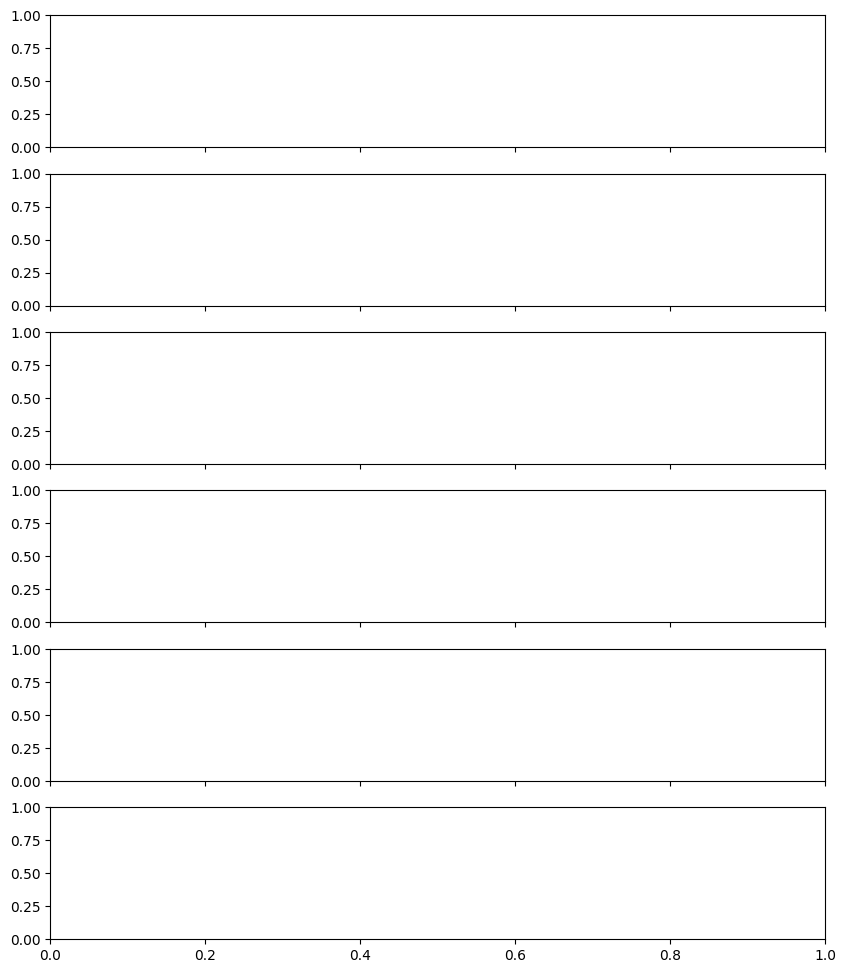

In [26]:
# Plot the simulation

fig, axs = plt.subplots(6, figsize=(10, 6 * 2.0), sharex=True, sharey=False)

axs[0].plot(competition_result.results[0].input_data.time, competition_result.results[0]
            .output_data.motor_target_throttle * 100, label="Motor Throttle (Input)")
axs[0].legend(loc="upper right")
axs[0].set_ylabel("Throttle [%]")

axs[1].plot(competition_result.results[0].input_data.time,
            competition_result.results[0].input_data.poa, label="Solar Radiation (Input)")
axs[1].legend(loc="upper right")
axs[1].set_ylabel("Radiation [W/m²]")

axs[2].plot(competition_result.results[0].input_data.time,
            competition_result.results[0].output_data.pv_output_power, label="PV (actual, output)")
axs[2].plot(competition_result.results[0].input_data.time,
            competition_result.results[0].output_data.pv_target_power, label="PV (target, internal signal)")
axs[2].legend(loc="upper right")
axs[2].set_ylabel("Power [W]")

axs[3].plot(competition_result.results[0].input_data.time,
            competition_result.results[0].output_data.motor_output_power, label="Motor (actual, output)")
axs[3].plot(competition_result.results[0].input_data.time,
            competition_result.results[0].output_data.motor_target_power, label="Motor (target, internal signal)")
axs[3].legend(loc="upper right")
axs[3].set_ylabel("Power [W]")

axs[4].plot(competition_result.results[0].input_data.time,
            competition_result.results[0].output_data.battery_output_power, label="Battery (actual, output)")
axs[4].plot(competition_result.results[0].input_data.time, competition_result.results[0]
            .output_data.battery_target_power, label="Battery (target, internal signal)")
axs[4].legend(loc="upper right")
axs[4].set_ylabel("Power [W]")

axs[5].plot(competition_result.results[0].input_data.time, competition_result.results[0]
            .output_data.battery_output_energy * 100, label="Battery (actual, output)")
axs[5].legend(loc="upper right")
axs[5].set_ylabel("SOC [%]")

plt.xlabel("Time [h]")
plt.suptitle("Boat Simulation Signals")
plt.tight_layout()
plt.show()
